In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
import random
import pandas as pd
import seaborn as sns

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_Data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9000 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septorial_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 4 7 8 3 4 1 8 3 7 8 3 6 0 0 8 3 2 3 5 6 4 8 4 6 7 1 0 8 4 3 6]


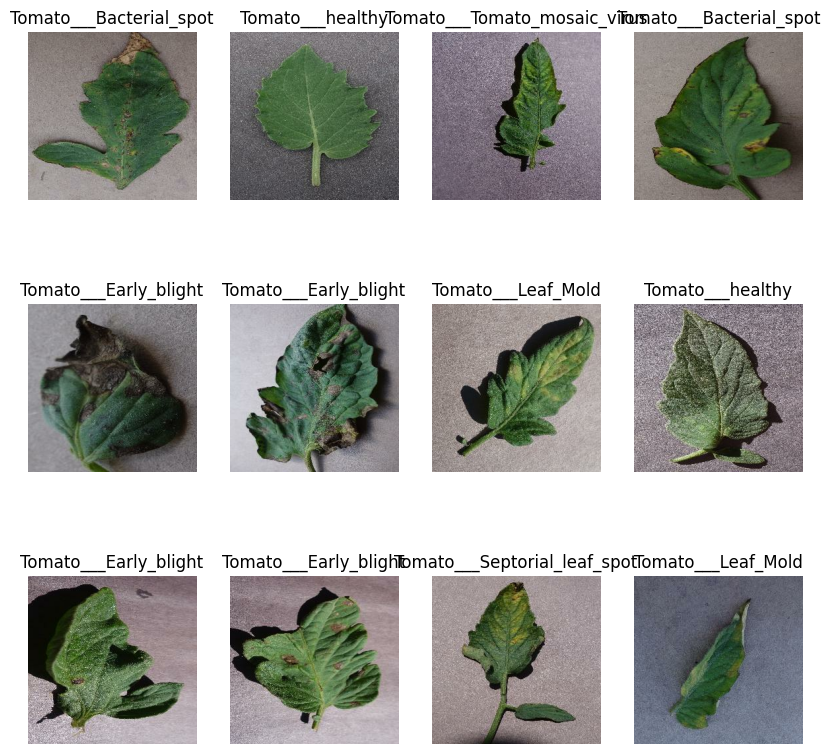

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
# creating training set, validation set and testing set
ds_size = len(dataset)

ds = dataset.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.8) # 80%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.10) # 10%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 282
Train set size : 225
Val set size   : 28
Test set size  : 29


In [8]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [11]:
train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 9

# model = models.Sequential([
#     resize_and_rescale,
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.2),
#     layers.Dense(n_classes, activation='softmax'),
# ])
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


In [16]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 254, 254, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 127, 127, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 125, 125, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 62, 62, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 60, 60, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (32, 57600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (32, 64)                    │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (32, 9)                     │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,710,633 (14.15 MB)

 Trainable params: 3,710,633 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_set,
    batch_size=BATCH_SIZE,
    validation_data=val_set,
    verbose=1,
    epochs=50,
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 193s 857ms/step - accuracy: 0.7489 - loss: 0.7234 - val_accuracy: 0.7812 - val_loss: 0.8185
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 189s 835ms/step - accuracy: 0.7637 - loss: 0.6515 - val_accuracy: 0.8192 - val_loss: 0.5272
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 193s 853ms/step - accuracy: 0.7702 - loss: 0.6670 - val_accuracy: 0.8002 - val_loss: 0.6143
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 191s 843ms/step - accuracy: 0.7763 - loss: 0.6275 - val_accuracy: 0.8739 - val_loss: 0.3625
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 188s 831ms/step - accuracy: 0.8004 - loss: 0.5798 - val_accuracy: 0.8415 - val_loss: 0.5232
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 186s 821ms/step - accuracy: 0.7990 - loss: 0.5481 - val_accuracy: 0.7846 - val_loss: 0.6776
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 197s 873ms/step - accuracy: 0.7963 - loss: 0.5460 - val_accuracy: 0.7679 - val_loss: 0.7654
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 200s 884ms/step - accuracy: 0.8021 -

In [20]:
loss,accuracy=model.evaluate(test_set)
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 78s 363ms/step - accuracy: 0.9455 - loss: 0.1660
Test Accuracy: 94.72%
Test Loss: 0.1615


In [21]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

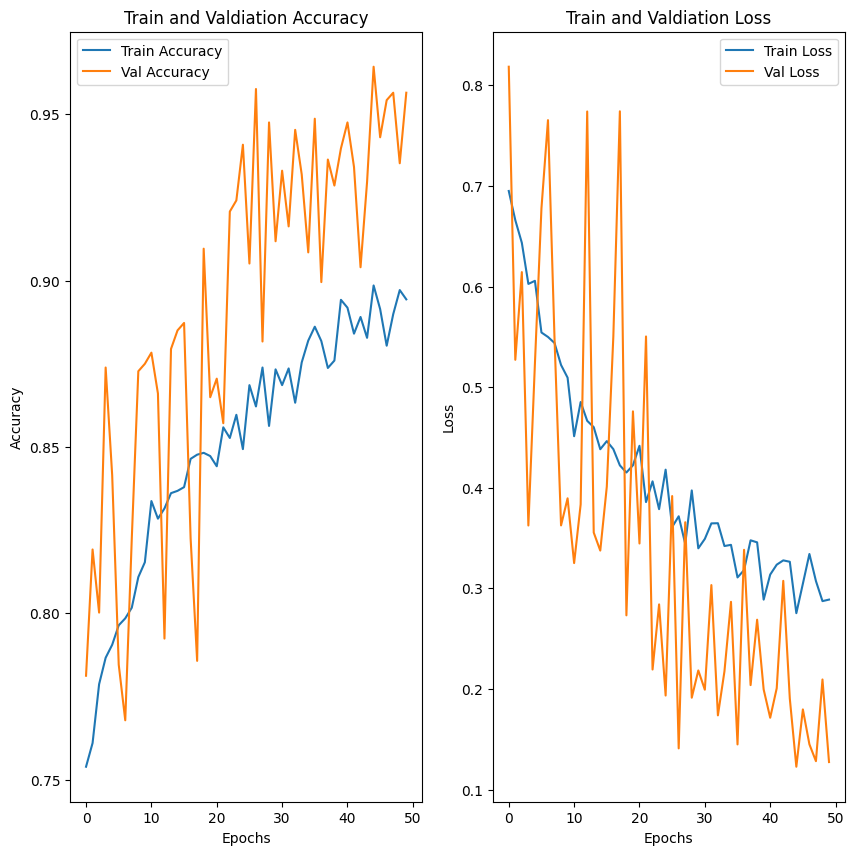

In [23]:
# plotting metrics at every epoch
train_metrics = [train_acc, train_loss]
val_metrics = [val_acc, val_loss]
metrics = ['Accuracy', 'Loss']

plt.figure(figsize=(10, 10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(50), train_metrics[i], label=f'Train {metrics[i]}')
    plt.plot(range(50), val_metrics[i], label=f'Val {metrics[i]}')
    plt.xlabel('Epochs')
    plt.ylabel(metrics[i])
    plt.title(f'Train and Valdiation {metrics[i]}')
    plt.legend()

In [24]:
import numpy as np
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_set.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [25]:
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [26]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[ 83   2   0   0   0   0   1   0   0]
 [  1 108   1   0   0   0   4   0   0]
 [  0   9  99   0   0   0   0   0   1]
 [  0   0   2 106  12   1   0   0   0]
 [  3   5   1   2  72   0   0   0   0]
 [  0   0   0   0   0  95   0   0   5]
 [  0   0   0   0   0   0 120   0   0]
 [  0   0   0   0   0   0   0  98   0]
 [  0   0   0   0   0   0   0   0  97]]


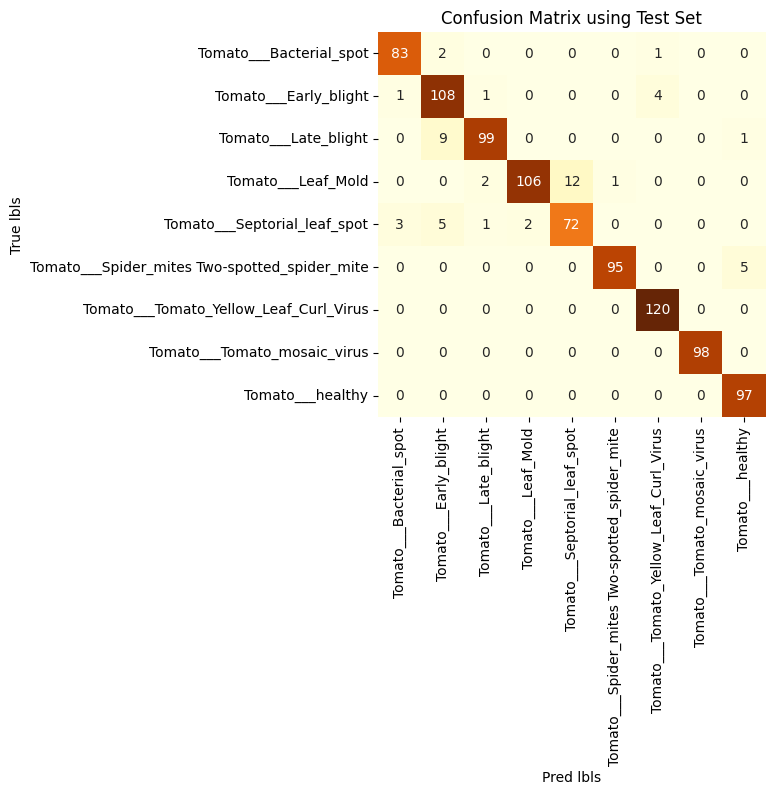

In [27]:
plt.figure(figsize=(5,5))
sns.heatmap(cf_matrix, annot=True, fmt='g', 
            xticklabels=class_names, yticklabels=class_names, 
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()

In [28]:
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [29]:
from tabulate import tabulate
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+-----------------------------------------------+-----+
| Tomato___Bacterial_spot                       |  86 |
+-----------------------------------------------+-----+
| Tomato___Early_blight                         | 114 |
+-----------------------------------------------+-----+
| Tomato___Late_blight                          | 109 |
+-----------------------------------------------+-----+
| Tomato___Leaf_Mold                            | 121 |
+-----------------------------------------------+-----+
| Tomato___Septorial_leaf_spot                  |  83 |
+-----------------------------------------------+-----+
| Tomato___Spider_mites Two-spotted_spider_mite | 100 |
+-----------------------------------------------+-----+
| Tomato___Tomato_Yellow_Leaf_Curl_Virus        | 120 |
+-----------------------------------------------+-----+
| Tomato___Tomato_mosaic_virus                  |  98 |
+-----------------------------------------------+-----+
| Tomato___healthy             

In [30]:
import pandas as pd
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s}, 
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
Tomato___Bacterial_spot,95.40%,96.51%,95.95%
Tomato___Early_blight,87.10%,94.74%,90.76%
Tomato___Late_blight,96.12%,90.83%,93.40%
Tomato___Leaf_Mold,98.15%,87.60%,92.58%
Tomato___Septorial_leaf_spot,85.71%,86.75%,86.23%
Tomato___Spider_mites Two-spotted_spider_mite,98.96%,95.00%,96.94%
Tomato___Tomato_Yellow_Leaf_Curl_Virus,96.00%,100.00%,97.96%
Tomato___Tomato_mosaic_virus,100.00%,100.00%,100.00%
Tomato___healthy,94.17%,100.00%,97.00%


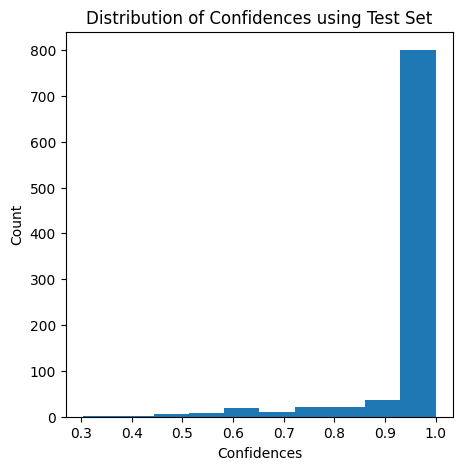

In [31]:
plt.figure(figsize=(5, 5))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

True lbl : Tomato___Tomato_mosaic_virus
Pred lbl : Tomato___Tomato_mosaic_virus
Conf     : 99.99%


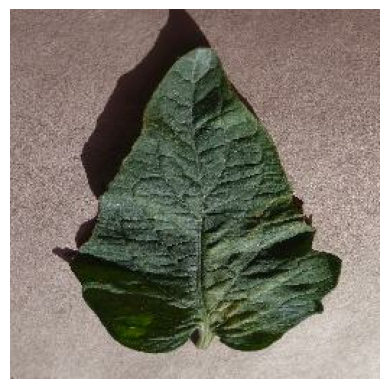

In [32]:
rand_batch = random.randint(1, test_size)
rand_img = random.randint(0, BATCH_SIZE - 1)

i = (rand_batch - 1) * BATCH_SIZE
lbl_true_name = lbls_true_names[i:i + BATCH_SIZE][rand_img]
lbl_pred_name = lbls_pred_names[i:i + BATCH_SIZE][rand_img]
pred_conf = pred_confs[i:i + BATCH_SIZE][rand_img]

print(f'True lbl : {lbl_true_name}')
print(f'Pred lbl : {lbl_pred_name}')
print(f'Conf     : {round(100 * pred_conf, 2)}%')

for imgs, lbls in test_set.take(rand_batch):
    plt.imshow(imgs[rand_img].numpy().astype('uint8'))
    plt.axis('off')
    break

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


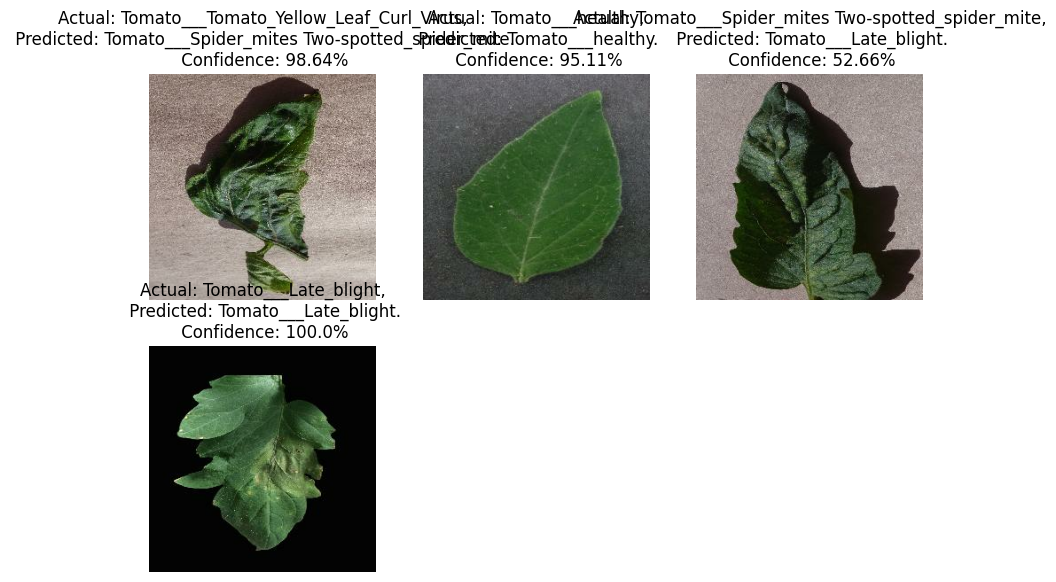

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
model.save('Model.h5')